## Objective
Train one model to make sure process of creating and training model works well

In [1]:
%load_ext autoreload

In [2]:
SAMP_FREQ = 20
SAMPLE_SIZE = 10 * SAMP_FREQ
FRONT_BUFFER = END_BUFFER = 2 * SAMP_FREQ
ISI_WF_MIN = round(0.2*SAMP_FREQ)

## Load Data
Needed for "Create and Train Model", "Cross validation models", "Tune loc prob thresh of model"

NOT needed for "Test performance of models"

In [3]:
%autoreload 2
import torch
from src import data, meta

cross_val = data.RecordingCrossVal(
    samples_per_waveform=(2, 20), front_buffer=FRONT_BUFFER, end_buffer=END_BUFFER,
    num_wfs_probs=[0.5, 0.3, 0.12, 0.06, 0.02], # None
    isi_wf_min=ISI_WF_MIN, isi_wf_max=None,
    rec_paths=meta.ORGANOID[:], thresh_amp=3*meta.GAIN_TO_UV,
    thresh_std=0.6,
    sample_size=SAMPLE_SIZE, start=0, ms_before=3, ms_after=3, gain_to_uv=meta.GAIN_TO_UV,
    device="cuda", dtype=torch.float16, mmap_mode="r",
    as_datasets=False,
    num_workers=0, shuffle=True, batch_size=1
)

In [14]:
# Get fold
rec, train, val = cross_val[-1]
cross_val.summarize(rec, train, val)

Val Recording: 5118 - Train: 988 samples - Val: 60 - Train/Val: 6.1%
Train num wfs probs:
0: 50.0%, 1: 30.0%, 2: 12.0%, 3: 6.0%, 4: 2.0%, 
Val num wfs probs:
0: 50.0%, 1: 30.0%, 2: 12.0%, 3: 6.0%, 4: 2.0%, 

In [ ]:
# Plot some example data

# as_datasets=False
for inputs, num_wfs, wf_locs, wf_alphas in val:
    for i in range(len(inputs)):
        train.plot_sample(inputs[i], num_wfs[i], wf_locs[i], wf_alphas[i])

# as_datasets=True
# alpha_to_waveform_dict = train.get_alpha_to_waveform_dict()
# for i in range(1, len(train), 2):
#     train.plot_sample(*train[i], alpha_to_waveform_dict)
# break

### Find number of waveforms in each recording

In [10]:
from src.data import MultiRecordingDataset
from src import meta

import numpy as np
import torch

num_wfs = []
for rec_path in meta.ORGANOID[:]:
    dataset = MultiRecordingDataset.load_single(path_folder=rec_path,
                                            samples_per_waveform=1, front_buffer=FRONT_BUFFER, end_buffer=END_BUFFER,
                                            num_wfs_probs=[0.5, 0.3, 0.12, 0.06, 0.02], isi_wf_min=ISI_WF_MIN, isi_wf_max=None,
                                            sample_size=SAMPLE_SIZE,
                                            device="cuda", dtype=torch.float16, gain_to_uv=meta.GAIN_TO_UV,
                                            thresh_amp=3*meta.GAIN_TO_UV, thresh_std=0.6)
    print(f"{rec_path.name}: {len(dataset)}")
    num_wfs.append(len(dataset))
num_wfs = np.array(num_wfs, dtype="float64")

2950: 36
2953: 239
2954: 82
2957: 64
5116: 73
5118: 3


In [11]:
print(f"Mean: {np.mean(num_wfs):.2f}")
print(f"STD: {np.std(num_wfs):.2f}")

Mean: 82.83
STD: 74.62


## Create and Train Model

In [5]:
assert False, "This was not actually used to train the DL model (this was copy and pasting from the single_neuropixels.ipynb. See train.py to see what was actually used)"

import time
%autoreload 2
from src.model import ModelSpikeSorter
from src.utils import random_seed

random_seed(2)

model = ModelSpikeSorter(
    num_channels_in=1, 
    sample_size=SAMPLE_SIZE, buffer_front_sample=FRONT_BUFFER, buffer_end_sample=END_BUFFER,
    loc_prob_thresh=35, buffer_front_loc=0, buffer_end_loc=0,
    input_scale=0.01,
    device="cuda", dtype=torch.float16,
    architecture_params=(
        -4, 50, "relu", 0, 0, 0, 0
    )
)
model.init_weights_and_biases("xavier", prelu_init=0)
model.model.init_final_bias(model.num_output_locs, val.num_wfs_probs)

model.fit(train, val, 
            num_epochs=200, epoch_patience=10, epoch_thresh=0.01,            
            lr=2e-4, # Retraining neuropixels right before Koch's visit
            
            # original MEA?
            # lr=7.76e-4, 
            momentum=0.85, 
            optim="momentum",
            
            lr_patience=5, lr_factor=0.4,
            tune_thresh_every=10, save_best=True)

Using random seed 2
Train: 4376 samples
Valid: 1438 samples
Num wfs probs: [0.5, 0.3, 0.12, 0.06, 0.02]

Before Training
Train: Loss: 5.099 | WF Detected: 0.0% | Accuracy: 99.6% | Recall: 0.0% | Precision: nan% | F1 Score: nan% | Loc MAD: nan frames = nan ms
Valid: Loss: 5.036 | WF Detected: 0.0% | Accuracy: 99.6% | Recall: 0.0% | Precision: nan% | F1 Score: nan% | Loc MAD: nan frames = nan ms

Epoch: 1/200
Train: Loss: 1.555 | WF Detected: 86.8% | Accuracy: 99.9% | Recall: 79.2% | Precision: 91.3% | F1 Score: 84.8% | Loc MAD: 0.27 frames = 0.0089 ms
Valid: Loss: 1.294 | WF Detected: 85.8% | Accuracy: 99.9% | Recall: 84.3% | Precision: 98.2% | F1 Score: 90.7% | Loc MAD: 0.25 frames = 0.0083 ms
Time: 37.65s

Epoch: 2/200
Train: Loss: 1.363 | WF Detected: 96.8% | Accuracy: 99.9% | Recall: 85.3% | Precision: 88.2% | F1 Score: 86.7% | Loc MAD: 0.26 frames = 0.0088 ms
Valid: Loss: 1.138 | WF Detected: 92.5% | Accuracy: 99.9% | Recall: 90.3% | Precision: 97.6% | F1 Score: 93.9% | Loc MAD: 0.

([(5.098572581734039, 0.0, 99.55768840138127, 0.0, nan, nan, nan, nan),
  (1.5550950814644642,
   86.76764789939983,
   99.87393357708714,
   79.19405544441268,
   91.27140974967062,
   84.80489671002294,
   0.26849512811259474,
   0.008949837603753157),
  (1.3631554452985035,
   96.77510608203677,
   99.88294738980296,
   85.34653465346534,
   88.19058754750073,
   86.74525589419206,
   0.26450116009280744,
   0.008816705336426915),
  (1.3217397812733485,
   94.4639718804921,
   99.88866036969327,
   84.38781487990627,
   89.33333333333333,
   86.79017924386203,
   0.2738632419298855,
   0.009128774730996183),
  (1.3821987329932846,
   83.19613965370424,
   99.84790777980906,
   74.59551518592109,
   89.66223132036848,
   81.43786798884413,
   0.20357686453576865,
   0.006785895484525622),
  (1.2981415021572078,
   91.94828092859242,
   99.8938655291489,
   83.6908610049956,
   91.01949504634068,
   87.20146968769136,
   0.26615168539325845,
   0.008871722846441948),
  (1.266795730242

In [6]:
# # Save model
# from pathlib import Path
# SAVE_PATH = Path("/data/MEAprojects/buzsaki/SiegleJ/AllenInstitute_744912849/session_766640955/dl_models/240227/c")
# ##
# model_name = model.save(SAVE_PATH)

# # Copy this notebook
# from src.utils import copy_file  
# copy_file("/data/MEAprojects/DLSpikeSorter/src/train/single.ipynb", SAVE_PATH / model_name / "src")

Not copying train.py


In [7]:
model.get_loc_prob_thresh()

22.499999403953552

In [ ]:
# from model import ModelSpikeSorter
# model = ModelSpikeSorter.load("/data/MEAprojects/buzsaki/SiegleJ/AllenInstitute_744912849/session_766640955/dl_models/230703/c")

# Plot performance
from utils import random_seed
random_seed(231)

model.tune_loc_prob_thresh(val, verbose=True)
perf = model.perf(val, plot_preds=('correct'), max_plots=30)
_ = model.perf_report("Probe C", perf)

## Cross validation models


In [5]:
import time
%autoreload 2
from src.model import ModelSpikeSorter
from src.utils import random_seed

from pathlib import Path
from src.utils import copy_file

SAVE_ROOT = Path("/data/MEAprojects/buzsaki/SiegleJ/AllenInstitute_744912849/session_766640955/dl_models/240116")

models_all = []
# for probe, (rec, train, val) in zip("abcdef", cross_val):
probes = "abcdef"
for idx in [4, 5]:
    probe = probes[idx]
    rec, train, val = cross_val[idx]
    
    cross_val.summarize(rec, train, val)
    
    random_seed(2)

    model = ModelSpikeSorter(
        num_channels_in=1, 
        sample_size=SAMPLE_SIZE, buffer_front_sample=FRONT_BUFFER, buffer_end_sample=END_BUFFER,
        loc_prob_thresh=35, buffer_front_loc=0, buffer_end_loc=0,
        input_scale=0.01,
        device="cuda", dtype=torch.float16,
        architecture_params=(
            -4, 50, "relu", 0, 0, 0, 0
        )
    )
    model.init_weights_and_biases("xavier", prelu_init=0)
    model.model.init_final_bias(model.num_output_locs, val.num_wfs_probs)

    model.fit(train, val, optim="momentum",
                num_epochs=200, epoch_patience=10, epoch_thresh=0.01,
                lr=2e-4,# 2.5e-4,
                # lr=7.76e-4, 
                momentum=0.85, lr_patience=5, lr_factor=0.4,
                tune_thresh_every=10, save_best=True)
    
    models_all.append(model)
    
    save_path = SAVE_ROOT / probe
    model_name = model.save(save_path)
    copy_file("/data/MEAprojects/DLSpikeSorter/src/train/single.ipynb", save_path / model_name / "src")

Val Recording: probe_773592328 - Train: 6382 samples - Val: 2034 - Train/Val: 31.9%
Train num wfs probs:
0: 63.9%, 1: 11.4%, 2: 9.5%, 3: 6.5%, 4: 4.1%, 5: 2.5%, 6: 1.2%, 7: 0.6%, 8: 0.2%, 
Val num wfs probs:
0: 55.6%, 1: 8.5%, 2: 9.0%, 3: 7.8%, 4: 6.1%, 5: 4.5%, 6: 3.3%, 7: 2.4%, 8: 1.7%, 9: 1.2%, Using random seed 2
Train: 6382 samples
Valid: 2034 samples
Num wfs probs: [0.63929545 0.11405971 0.09547528 0.0654255  0.04146594 0.0246146
 0.01153711 0.00603991 0.0020865 ]

Before Training
Train: Loss: 6.010 | WF Detected: 0.0% | Accuracy: 99.5% | Recall: 0.0% | Precision: nan% | F1 Score: nan% | Loc MAD: nan frames = nan ms
Valid: Loss: 9.431 | WF Detected: 0.0% | Accuracy: 99.1% | Recall: 0.0% | Precision: nan% | F1 Score: nan% | Loc MAD: nan frames = nan ms

Epoch: 1/200
Train: Loss: 9.842 | WF Detected: 10.3% | Accuracy: 99.5% | Recall: 3.3% | Precision: 31.8% | F1 Score: 5.9% | Loc MAD: 0.67 frames = 0.0222 ms
Valid: Loss: 7.526 | WF Detected: 10.2% | Accuracy: 99.2% | Recall: 4.1% |

In [24]:
# for probe, model in zip("abcdef", models_all):
#     model.save(f"/data/MEAprojects/DLSpikeSorter/models/{probe}")

In [26]:
model_b = models_all[1]

In [1]:
# rec, train, val = cross_val[0]

In [ ]:
from utils import random_seed
random_seed(100)
_ = model_b.perf_report("Val", model_b.perf(val, plot_preds=("failed"), max_plots=20))

## Tune loc prob thresh of a model
Set the loose threshold as the point where recall = X * precision or where recall = precision + Y

In [23]:
from src import utils
from src.model import ModelSpikeSorter
utils.random_seed(231)
model = ModelSpikeSorter.load("/data/MEAprojects/DLSpikeSorter/models/v0_4_4/5118/230101_135307_305876")
model.tune_loc_prob_thresh(train, stop=35)

Using random seed 231
Prob Thresh: 2.5%: Loss: 1.232 | WF Detected: 160.6% | Accuracy: 99.6% | Recall: 96.1% | Precision: 59.9% | F1 Score: 73.8% | Loc MAD: 0.26 frames = 0.0129 ms
F1 Score: 73.8

Prob Thresh: 5.0%: Loss: 1.232 | WF Detected: 139.0% | Accuracy: 99.7% | Recall: 95.2% | Precision: 68.5% | F1 Score: 79.7% | Loc MAD: 0.26 frames = 0.0131 ms
F1 Score: 79.7

Prob Thresh: 7.5%: Loss: 1.232 | WF Detected: 128.3% | Accuracy: 99.7% | Recall: 94.4% | Precision: 73.6% | F1 Score: 82.7% | Loc MAD: 0.26 frames = 0.0132 ms
F1 Score: 82.7

Prob Thresh: 10.0%: Loss: 1.232 | WF Detected: 121.2% | Accuracy: 99.8% | Recall: 93.6% | Precision: 77.2% | F1 Score: 84.6% | Loc MAD: 0.29 frames = 0.0143 ms
F1 Score: 84.6

Prob Thresh: 12.5%: Loss: 1.232 | WF Detected: 115.5% | Accuracy: 99.8% | Recall: 93.0% | Precision: 80.5% | F1 Score: 86.3% | Loc MAD: 0.28 frames = 0.0141 ms
F1 Score: 86.3

Prob Thresh: 15.0%: Loss: 1.232 | WF Detected: 111.8% | Accuracy: 99.8% | Recall: 91.6% | Precision: 

## Test performance of models

In [23]:
import torch

from src.model import ModelSpikeSorter
from src import utils, meta
from src.data import MultiRecordingDataset, RecordingDataloader

MODEL_PATHS = [
    "/data/MEAprojects/DLSpikeSorter/models/v0_4_4/2950/230101_133131_959516",
    "/data/MEAprojects/DLSpikeSorter/models/v0_4_4/2953/230101_133514_582221",
    "/data/MEAprojects/DLSpikeSorter/models/v0_4_4/2954/230101_134042_729459",
    "/data/MEAprojects/DLSpikeSorter/models/v0_4_4/2957/230101_134408_403069",
    "/data/MEAprojects/DLSpikeSorter/models/v0_4_4/5116/230101_134927_487762",
    "/data/MEAprojects/DLSpikeSorter/models/v0_4_4/5118/230101_135307_305876",
    "/data/MEAprojects/DLSpikeSorter/models/v0_4_4/5118/230101_135307_305876",
]
REC_PATHS = meta.ORGANOID[:]

In [24]:
# General performance
all_dataloaders = []
all_models = []
for i, (model_path, rec_path) in enumerate(zip(MODEL_PATHS, REC_PATHS)):
    utils.random_seed(231)
    dataset = MultiRecordingDataset.load_single(path_folder=rec_path,
                                            samples_per_waveform=20, front_buffer=FRONT_BUFFER, end_buffer=END_BUFFER,
                                            num_wfs_probs=[0.5, 0.3, 0.12, 0.06, 0.02], isi_wf_min=ISI_WF_MIN, isi_wf_max=None, use_positive_peaks=True,
                                            sample_size=SAMPLE_SIZE,
                                            device="cuda", dtype=torch.float16, gain_to_uv=meta.GAIN_TO_UV,
                                            thresh_amp=3*meta.GAIN_TO_UV, thresh_std=0.6)
    dataloader = RecordingDataloader(dataset)
    all_dataloaders.append(dataloader)
    
    model = ModelSpikeSorter.load(model_path)
    _ = model.perf_report("Val", model.perf(dataloader))
    all_models.append(model)

Using random seed 231
Val: Loss: 0.702 | WF Detected: 95.8% | Accuracy: 99.9% | Recall: 91.1% | Precision: 95.1% | F1 Score: 93.0% | Loc MAD: 0.10 frames = 0.0049 ms
Using random seed 231
Val: Loss: 1.017 | WF Detected: 91.8% | Accuracy: 99.9% | Recall: 86.8% | Precision: 94.6% | F1 Score: 90.5% | Loc MAD: 0.18 frames = 0.0090 ms
Using random seed 231
Val: Loss: 0.772 | WF Detected: 96.0% | Accuracy: 99.9% | Recall: 92.4% | Precision: 96.2% | F1 Score: 94.3% | Loc MAD: 0.14 frames = 0.0069 ms
Using random seed 231
Val: Loss: 1.299 | WF Detected: 98.1% | Accuracy: 99.8% | Recall: 86.6% | Precision: 88.4% | F1 Score: 87.5% | Loc MAD: 0.25 frames = 0.0124 ms
Using random seed 231
Val: Loss: 1.053 | WF Detected: 92.8% | Accuracy: 99.9% | Recall: 85.3% | Precision: 92.0% | F1 Score: 88.5% | Loc MAD: 0.27 frames = 0.0134 ms
Using random seed 231
Val: Loss: 0.362 | WF Detected: 114.5% | Accuracy: 99.9% | Recall: 100.0% | Precision: 87.3% | F1 Score: 93.2% | Loc MAD: 0.00 frames = 0.0000 ms


In [25]:
# Performance vs prob thresh
import numpy as np
from tqdm import tqdm

START = 2.5
STOP = 97.5
STEP = 2.5
##
num = int(STOP//STEP)
threshes = np.linspace(START, num * STEP, num)
f1_means = []
f1_stds = []
recall_means = []
recall_stds = []
precision_means = []
precision_stds = []

all_loc_prob_thresh_tuning_data = [] # (num_threshes, 6 [6 models], 4 [thresh, f1, recall, precision])
for thresh in tqdm(threshes):
    loc_prob_thresh_tuning_data = []
    
    f1s = []
    recalls = []
    precisions = []
    for model, dataloader in zip(all_models, all_dataloaders):
        model.set_loc_prob_thresh(thresh)
        perf = model.perf(dataloader)
        f1 = perf[5]
        recall = perf[3]
        precision = perf[4]
        
        f1s.append(f1)
        recalls.append(recall)
        precisions.append(precision)
        
        loc_prob_thresh_tuning_data.append([thresh, f1, recall, precision])
        
    f1_means.append(np.mean(f1s))
    f1_stds.append(np.std(f1s))
    recall_means.append(np.mean(recalls))
    recall_stds.append(np.std(recalls))
    precision_means.append(np.mean(precisions))
    precision_stds.append(np.std(precisions))
    
    all_loc_prob_thresh_tuning_data.append(loc_prob_thresh_tuning_data)
all_loc_prob_thresh_tuning_data = np.array(all_loc_prob_thresh_tuning_data)

100%|██████████| 39/39 [12:03<00:00, 18.56s/it]


In [26]:
np.save("/data/MEAprojects/DLSpikeSorter/models/v0_4_4/all_loc_prob_thresh_tuning_data_with_positive_peaks.npy", all_loc_prob_thresh_tuning_data)

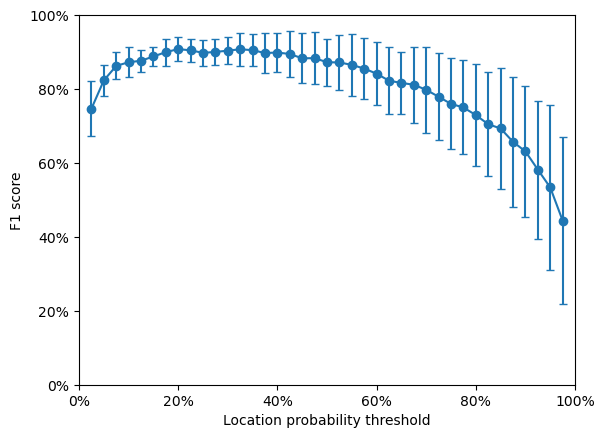

In [8]:
import matplotlib.pyplot as plt
YTICKS = range(0, 101, 20)
XTICKS = YTICKS

plt.errorbar(threshes, f1_means, yerr=f1_stds, fmt='o-', capsize=3)
plt.xlabel('Location probability threshold')
plt.ylabel('F1 score')
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.yticks(YTICKS, [str(x)+"%" for x in YTICKS])
plt.xticks(XTICKS, [str(x)+"%" for x in XTICKS])

plt.show()

# SAVE_NAME = "f1_score_vs_probability_thresh"
# import pickle
# plt.savefig(f"/data/MEAprojects/RT-Sort/figures/230119_presentation/{SAVE_NAME}.png", format="png")
# with open(f'/data/MEAprojects/RT-Sort/figures/230119_presentation/{SAVE_NAME}.pickle', "wb") as file:
#     pickle.dump(plt.gcf(), file)

In [13]:
for thresh, recall, precision, f1 in zip(threshes, recall_means, precision_means, f1_means):
    print(f"Prob thresh: {thresh:.1f}%: Recall: {recall:.1f}% | Precision: {precision:.1f}% | F1 Score: {f1:.1f}%")

Prob thresh: 2.5%: Recall: 97.2% | Precision: 64.4% | F1 Score: 76.9%
Prob thresh: 5.0%: Recall: 96.2% | Precision: 72.3% | F1 Score: 82.1%
Prob thresh: 7.5%: Recall: 94.6% | Precision: 79.4% | F1 Score: 86.3%
Prob thresh: 10.0%: Recall: 94.7% | Precision: 82.1% | F1 Score: 87.9%
Prob thresh: 12.5%: Recall: 93.7% | Precision: 83.9% | F1 Score: 88.4%
Prob thresh: 15.0%: Recall: 93.0% | Precision: 86.1% | F1 Score: 89.3%
Prob thresh: 17.5%: Recall: 92.1% | Precision: 87.3% | F1 Score: 89.5%
Prob thresh: 20.0%: Recall: 91.4% | Precision: 90.7% | F1 Score: 90.9%
Prob thresh: 22.5%: Recall: 90.7% | Precision: 90.5% | F1 Score: 90.5%
Prob thresh: 25.0%: Recall: 90.1% | Precision: 89.1% | F1 Score: 89.3%
Prob thresh: 27.5%: Recall: 89.4% | Precision: 91.0% | F1 Score: 89.9%
Prob thresh: 30.0%: Recall: 88.2% | Precision: 92.1% | F1 Score: 89.9%


### Test performance when using a unit's X highest waveform
INCOMPLETE

In [6]:
import torch

from src.model import ModelSpikeSorter
from src import utils, meta
from src.data import MultiRecordingDataset, RecordingDataloader

MODEL_PATHS = [
    "/data/MEAprojects/DLSpikeSorter/models/v0_4_4/2950/230101_133131_959516",
    "/data/MEAprojects/DLSpikeSorter/models/v0_4_4/2953/230101_133514_582221",
    "/data/MEAprojects/DLSpikeSorter/models/v0_4_4/2954/230101_134042_729459",
    "/data/MEAprojects/DLSpikeSorter/models/v0_4_4/2957/230101_134408_403069",
    "/data/MEAprojects/DLSpikeSorter/models/v0_4_4/5116/230101_134927_487762",
    "/data/MEAprojects/DLSpikeSorter/models/v0_4_4/5118/230101_135307_305876",
    "/data/MEAprojects/DLSpikeSorter/models/v0_4_4/5118/230101_135307_305876",
]
REC_PATHS = meta.ORGANOID[:]

In [ ]:
X_VALUES = []

all_dataloaders = []
all_models = []
for i, (model_path, rec_path) in enumerate(zip(MODEL_PATHS, REC_PATHS)):
    print(f"\nRecording {rec_path.name}")
    utils.random_seed(231)
    dataset = MultiRecordingDataset.load_single(path_folder=rec_path,
                                            samples_per_waveform=20, front_buffer=FRONT_BUFFER, end_buffer=END_BUFFER,
                                            num_wfs_probs=[0.5, 0.3, 0.12, 0.06, 0.02], isi_wf_min=ISI_WF_MIN, isi_wf_max=None,
                                            sample_size=SAMPLE_SIZE,
                                            device="cuda", dtype=torch.float16, gain_to_uv=meta.GAIN_TO_UV,
                                            thresh_amp=3*meta.GAIN_TO_UV, thresh_std=0.6,
                                            x_highest=0)
    print(f"{len(dataset)//dataset.samples_per_waveform} waveforms")
    dataloader = RecordingDataloader(dataset)
    all_dataloaders.append(dataloader)
    
    model = ModelSpikeSorter.load(model_path)
    _ = model.perf_report("Val", model.perf(dataloader))
    all_models.append(model)

In [8]:
len(dataloader)

520

### Test performance as function of ms before and after peak

In [4]:
import torch

%autoreload 2
from src.model import ModelSpikeSorter
from src import utils, meta
from src.data import MultiRecordingDataset, RecordingDataloader, RecordingCrossVal

MODEL_PATHS = [
    "/data/MEAprojects/DLSpikeSorter/models/v0_4_4/2950/230101_133131_959516",
    "/data/MEAprojects/DLSpikeSorter/models/v0_4_4/2953/230101_133514_582221",
    "/data/MEAprojects/DLSpikeSorter/models/v0_4_4/2954/230101_134042_729459",
    "/data/MEAprojects/DLSpikeSorter/models/v0_4_4/2957/230101_134408_403069",
    "/data/MEAprojects/DLSpikeSorter/models/v0_4_4/5116/230101_134927_487762",
    "/data/MEAprojects/DLSpikeSorter/models/v0_4_4/5118/230101_135307_305876",
    "/data/MEAprojects/DLSpikeSorter/models/v0_4_4/5118/230101_135307_305876",
]
REC_PATHS = meta.ORGANOID[:]

In [ ]:
# General performance
MSES_BEFORE_AFTER = [5, 0.05]

for i, (model_path, rec_path) in enumerate(zip(MODEL_PATHS, REC_PATHS)):
    model = ModelSpikeSorter.load(model_path)
    
    for ms_before_after in MSES_BEFORE_AFTER:
        utils.random_seed(231)
        dataset = MultiRecordingDataset.load_single(path_folder=rec_path,
                                                samples_per_waveform=20, front_buffer=FRONT_BUFFER, end_buffer=END_BUFFER,
                                                num_wfs_probs=[0.5, 0.3, 0.12, 0.06, 0.02], isi_wf_min=ISI_WF_MIN, isi_wf_max=None, use_positive_peaks=True, ms_before_after=(ms_before_after, 20, 100),
                                                sample_size=SAMPLE_SIZE,
                                                device="cuda", dtype=torch.float16, gain_to_uv=meta.GAIN_TO_UV,
                                                thresh_amp=3*meta.GAIN_TO_UV, thresh_std=0.6)
        dataloader = RecordingDataloader(dataset)
        all_dataloaders.append(dataloader)
        
        perf = model.perf(dataloader)
        _ = model.perf_report(rec_path.name, perf)
    
        # f1s = []
        # recalls = []
        # precisions = []
        # for model, dataloader in zip(all_models, all_dataloaders):
        #     model.set_loc_prob_thresh(thresh)
        #     perf = model.perf(dataloader)
        #     f1 = perf[5]
        #     recall = perf[3]
        #     precision = perf[4]
            
        #     f1s.append(f1)
        #     recalls.append(recall)
        #     precisions.append(precision)
            
        #     loc_prob_thresh_tuning_data.append([thresh, f1, recall, precision])

In [ ]:
import numpy as np
npz = np.load(REC_PATHS[1] / "sorted.npz", allow_pickle=True)
for unit in npz["units"]:
    max_chan = unit['max_channel_si']
    peak_idx = unit['peak_ind'][max_chan]
    npz_temp = unit['template'][:, max_chan]
    temp = templates[unit["unit_id"], :, max_chan]
    if npz_temp[peak_idx] > 0:
        plt.plot(npz_temp)
        plt.show()
        print('2ez')

In [29]:
import matplotlib.pyplot as plt

In [10]:
%autoreload
from src.data import WaveformDataset
WaveformDataset(REC_PATHS[4], 19, 0.6)

In [34]:
npz['fs']/1000

20.0

In [20]:
templates = np.load("/data/MEAprojects/DLSpikeSorter/data/2953/spikesort_matlab4/waveforms/templates/templates_average.npy", mmap_mode="r")
templates.shape

(357, 201, 1020)

In [5]:
MSES_BEFORE_AFTER = [3, 2, 1, 0.5, 0.2, 0.1, 0.05]

from pathlib import Path
SAVE_ROOT = Path("/data/MEAprojects/DLSpikeSorter/models/ms_before_after_testing")

In [7]:
performances = []  # (N=num ms_before_after tested, 6=6 DL models, 3=ms_before_after; recall; precision)
for ms_before_after in MSES_BEFORE_AFTER:
    print("="*50)
    print(f"STARTING ON {ms_before_after}ms")
    print("="*50)
    dl_perfs = []
    for i in range(6):
        utils.random_seed(231)
        
        cross_val = RecordingCrossVal(
            samples_per_waveform=(2, 20), front_buffer=FRONT_BUFFER, end_buffer=END_BUFFER,
            num_wfs_probs=[0.5, 0.3, 0.12, 0.06, 0.02], # None
            isi_wf_min=ISI_WF_MIN, isi_wf_max=None,
            rec_paths=meta.ORGANOID[:], thresh_amp=3*meta.GAIN_TO_UV,
            thresh_std=0.6, use_positive_peaks=True, ms_before_after=(ms_before_after, 20, 100),
            sample_size=SAMPLE_SIZE, start=0, ms_before=3, ms_after=3, gain_to_uv=meta.GAIN_TO_UV,
            device="cuda", dtype=torch.float16, mmap_mode="r",
            as_datasets=False,
            num_workers=0, shuffle=True, batch_size=1
        )

        rec, train, val = cross_val[i]

        model = ModelSpikeSorter(
            num_channels_in=1, 
            sample_size=SAMPLE_SIZE, buffer_front_sample=FRONT_BUFFER, buffer_end_sample=END_BUFFER,
            loc_prob_thresh=35, buffer_front_loc=0, buffer_end_loc=0,
            input_scale=0.01,
            device="cuda", dtype=torch.float16,
            architecture_params=(
                4, 50, "relu", 0, 0, 0, 0
            )
        )
        model.init_weights_and_biases("xavier", prelu_init=0)
        model.model.init_final_bias(model.num_output_locs, val.num_wfs_probs)
        model.fit(train, val, 
                    num_epochs=200, epoch_patience=10, epoch_thresh=0.01,            
                    lr=7.76e-4, 
                    momentum=0.85, 
                    optim="momentum",
                    
                    lr_patience=5, lr_factor=0.4,
                    tune_thresh_every=10, save_best=True)
        
        save_path = SAVE_ROOT / str(ms_before_after) / rec
        model_name = model.save(save_path)
        utils.copy_file("/data/MEAprojects/DLSpikeSorter/src/train/single_mea.ipynb", save_path / model_name / "src")
        
        perf = model.perf(val)
        # f1 = perf[5]
        recall = perf[3]
        precision = perf[4]
        dl_perfs.append([ms_before_after, recall, precision])
    performances.append(dl_perfs)
performances = np.array(performances)
np.save(SAVE_ROOT / "performances.npy", performances)

STARTING ON 3ms
Using random seed 231
Train: 922 samples
Valid: 720 samples
Num wfs probs: [0.5, 0.3, 0.12, 0.06, 0.02]

Before Training
Train: Loss: 4.680 | WF Detected: 0.0% | Accuracy: 99.4% | Recall: 0.0% | Precision: nan% | F1 Score: nan% | Loc MAD: nan frames = nan ms
Valid: Loss: 5.209 | WF Detected: 0.0% | Accuracy: 99.3% | Recall: 0.0% | Precision: nan% | F1 Score: nan% | Loc MAD: nan frames = nan ms

Epoch: 1/200
Train: Loss: 2.182 | WF Detected: 55.9% | Accuracy: 99.7% | Recall: 54.0% | Precision: 96.6% | F1 Score: 69.3% | Loc MAD: 0.25 frames = 0.0125 ms
Valid: Loss: 1.892 | WF Detected: 64.4% | Accuracy: 99.8% | Recall: 63.9% | Precision: 99.2% | F1 Score: 77.7% | Loc MAD: 0.16 frames = 0.0080 ms
Time: 8.55s

Epoch: 2/200
Train: Loss: 1.691 | WF Detected: 75.7% | Accuracy: 99.8% | Recall: 71.3% | Precision: 94.3% | F1 Score: 81.2% | Loc MAD: 0.24 frames = 0.0118 ms
Valid: Loss: 1.181 | WF Detected: 82.7% | Accuracy: 99.8% | Recall: 79.4% | Precision: 95.9% | F1 Score: 86.9

NameError: name 'np' is not defined

In [8]:
import numpy as np
performances = np.array(performances)
np.save(SAVE_ROOT / "performances.npy", performances)

In [21]:
str(SAVE_ROOT / "performances.npy")

'/data/MEAprojects/DLSpikeSorter/models/ms_before_after_testing/performances.npy'

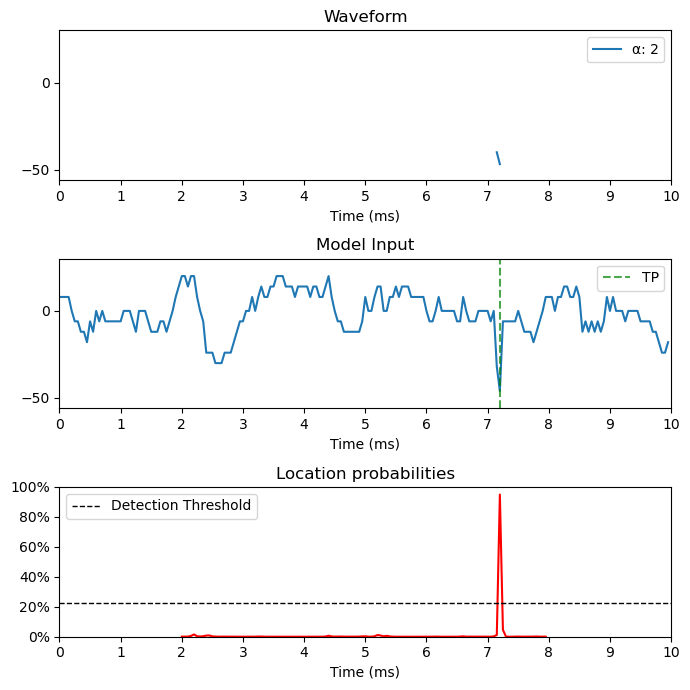

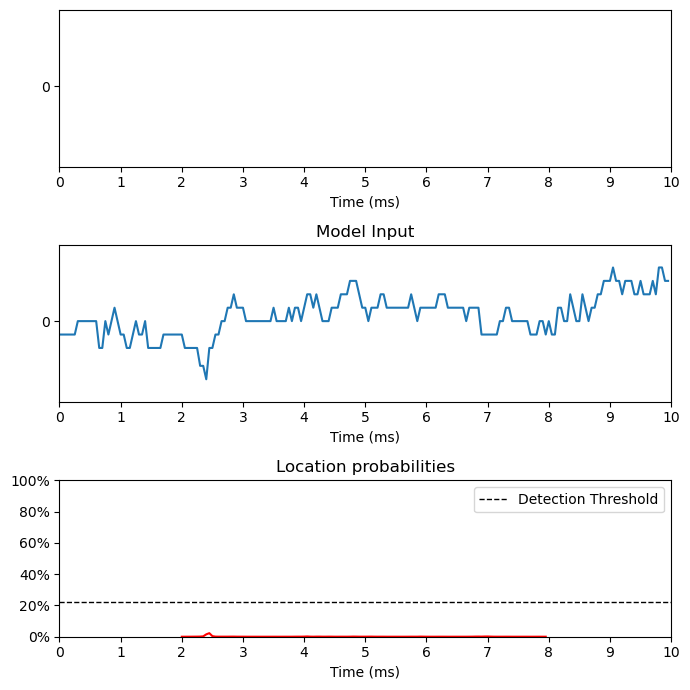

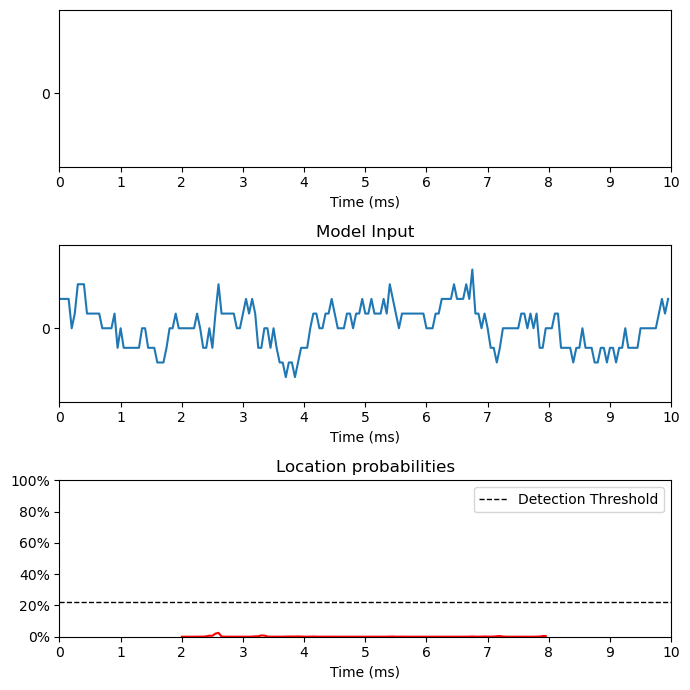

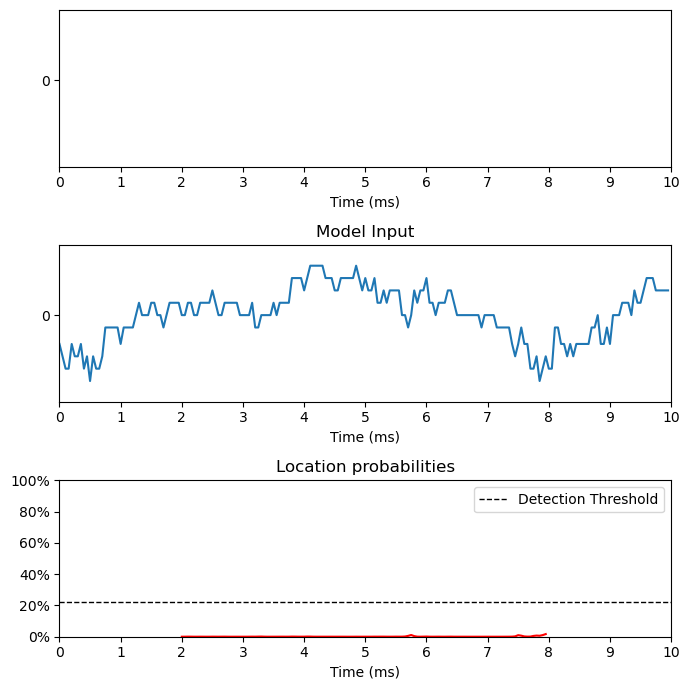

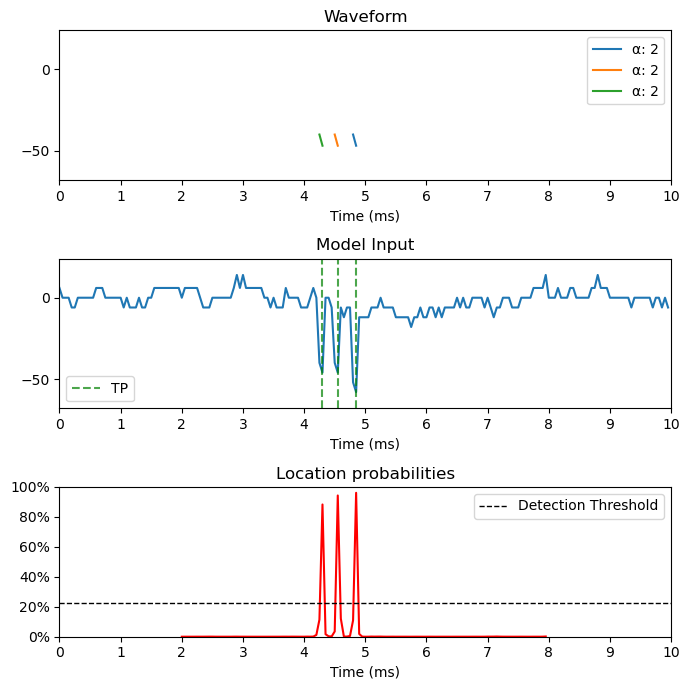

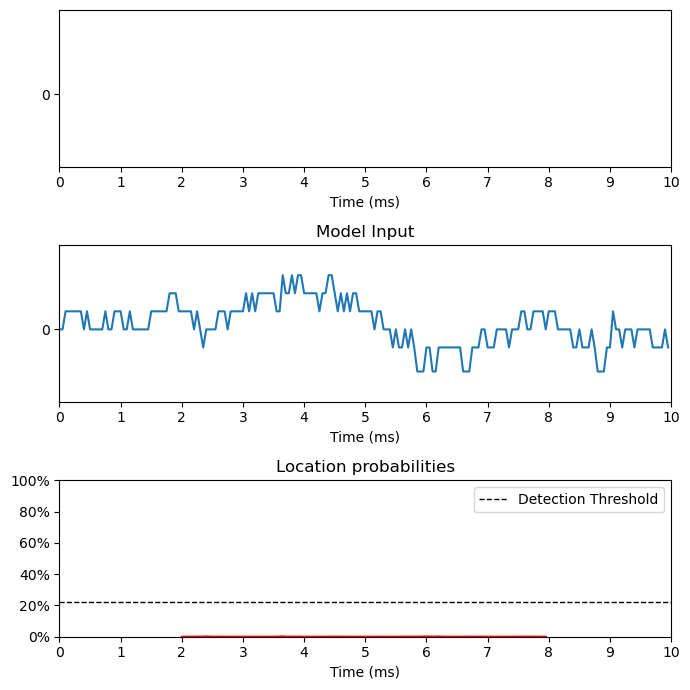

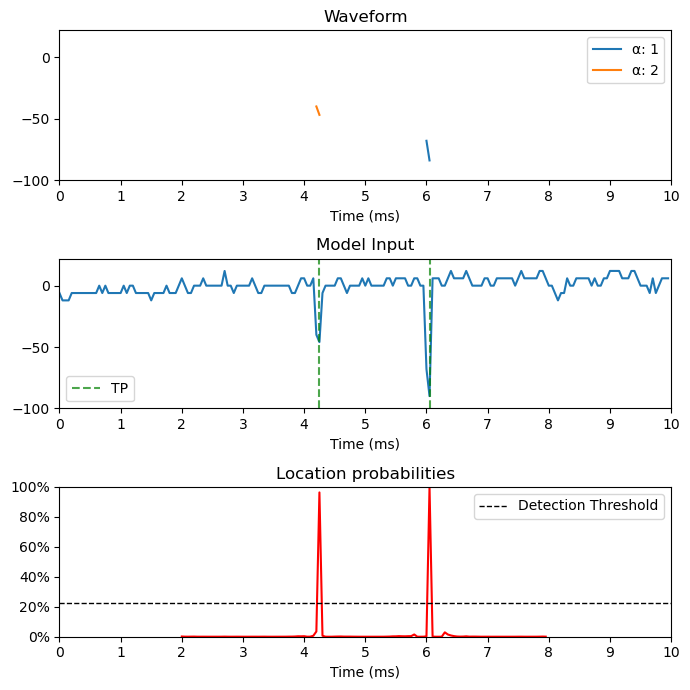

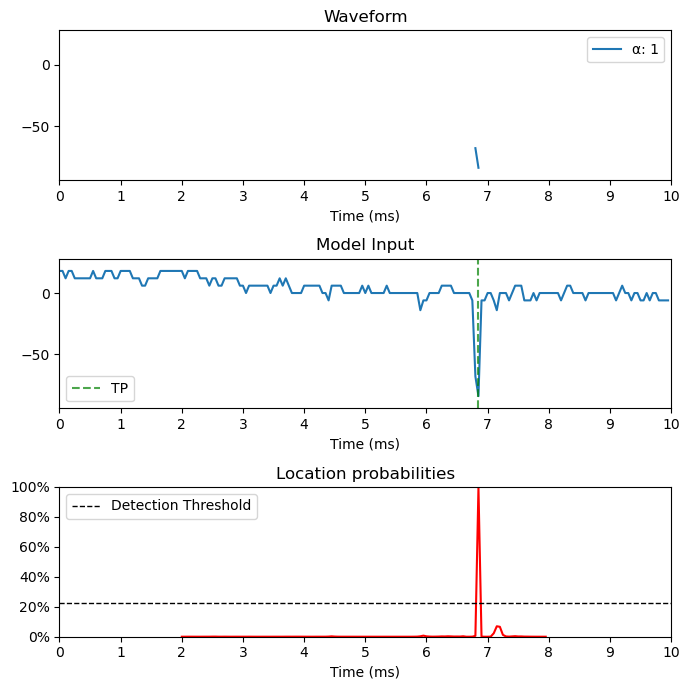

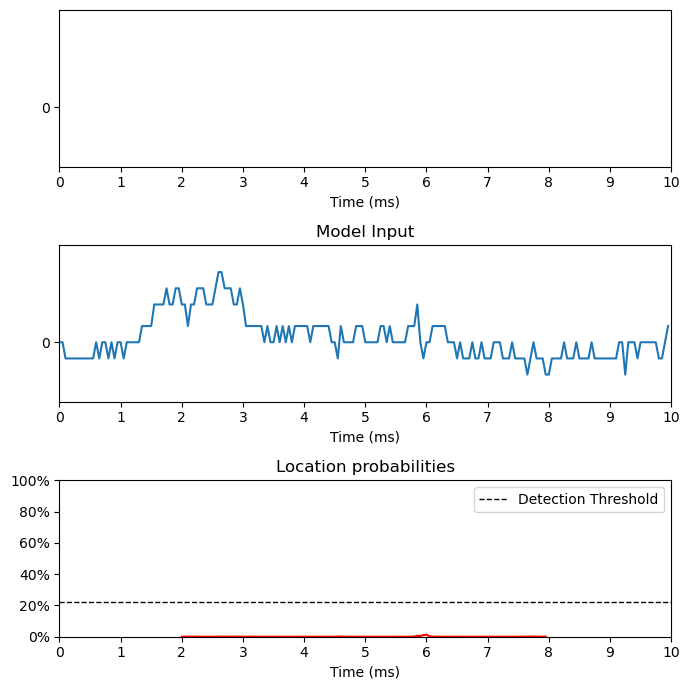

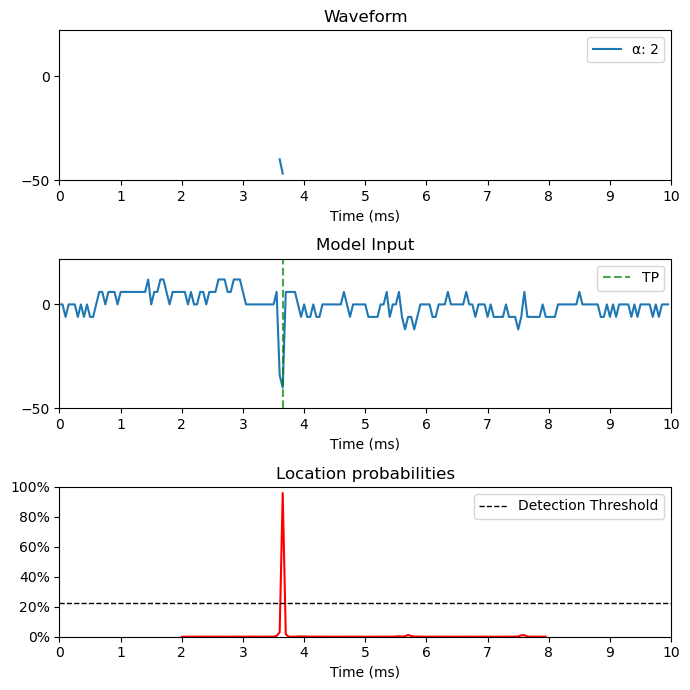

(0.2940942347049713, 100.0, 100.0, 100.0, 100.0, 100.0, 0.0, 0.0)

In [22]:
model.perf(val, plot_preds=("all",))

In [20]:
val.dataset.wf_datasets[0].waveforms[0].waveform

memmap([-132.28603, -162.92708], dtype=float32)